In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# !git clone https://github.com/hyeshik/colab-biolab.git
# !cd colab-biolab && bash tools/setup.sh
# exec(open('colab-biolab/tools/activate_conda.py').read())

In [4]:
%cd /content/drive/MyDrive/binfo1-work/

/content/drive/MyDrive/binfo1-work


In [5]:
# !conda install -y subread
# !ls
# !pwd
# !featureCounts -h
# !featureCounts -a gencode.gtf  -o /content/drive/MyDrive/YOA/read-counts.txt  CLIP-35L33G.bam	 RNA-control.bam		RNA-siLin28a.bam	RNA-siLuc.bam RPF-siLin28a.bam RPF-siLuc.bam

In [29]:
import pandas as pd
cnts = pd.read_csv('read-counts.txt', sep='\t', comment='#', index_col=0)

In [30]:
import numpy as np
cnts['clip_enrichment'] = cnts['CLIP-35L33G.bam'] / cnts['RNA-control.bam']
cnts['rden_change'] = (cnts['RPF-siLin28a.bam'] / cnts['RNA-siLin28a.bam']) / (cnts['RPF-siLuc.bam'] / cnts['RNA-siLuc.bam'])

cnts['clip_enrichment_log2'] = np.log2((cnts['CLIP-35L33G.bam'] + 1) / (cnts['RNA-control.bam'] + 1))
cnts['rden_siLin28a'] = (cnts['RPF-siLin28a.bam'] + 1) / (cnts['RNA-siLin28a.bam'] + 1)
cnts['rden_siLuc']     = (cnts['RPF-siLuc.bam'] + 1) / (cnts['RNA-siLuc.bam'] + 1)
cnts['rden_change_log2'] = np.log2(cnts['rden_siLin28a'] / cnts['rden_siLuc'])

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


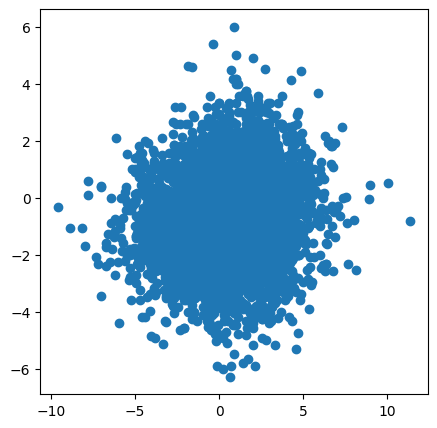

In [31]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(np.log2(cnts['clip_enrichment']),
           np.log2(cnts['rden_change']))

0.2059328289045011


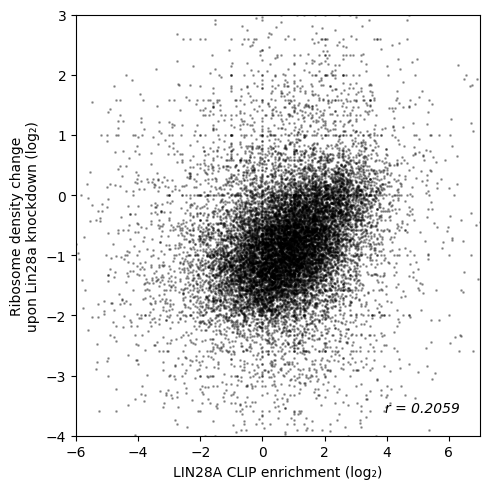

In [32]:
from scipy.stats import pearsonr

# 양수일 때만 log2가 유효하므로 그것만 사용
mask = (cnts['clip_enrichment'] > 0) & (cnts['rden_change'] > 0)
cnts_filtered = cnts[mask].copy()
cnts_filtered['clip_enrichment_log2'] = np.log2(cnts_filtered['clip_enrichment'])
cnts_filtered['rden_change_log2'] = np.log2(cnts_filtered['rden_change'])

# Inf/NaN 제거
cnts_filtered = cnts_filtered.replace([np.inf, -np.inf], np.nan).dropna(subset=['clip_enrichment_log2', 'rden_change_log2'])

# r 계산
r, _ = pearsonr(cnts_filtered['clip_enrichment_log2'], cnts_filtered['rden_change_log2'])

print(r)
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(cnts_filtered['clip_enrichment_log2'], cnts_filtered['rden_change_log2'], s=1, alpha=0.3, color='black')

ax.set_xlabel('LIN28A CLIP enrichment (log₂)')
ax.set_ylabel('Ribosome density change\nupon Lin28a knockdown (log₂)')
ax.set_xlim(-6, 7)
ax.set_ylim(-4, 3)

ax.text(0.95, 0.05, f'r = {r:.4f}', transform=ax.transAxes,
        ha='right', va='bottom', fontsize=10, style='italic')
plt.tight_layout()
plt.savefig("YOA1.png", dpi=300, bbox_inches='tight')
plt.show()


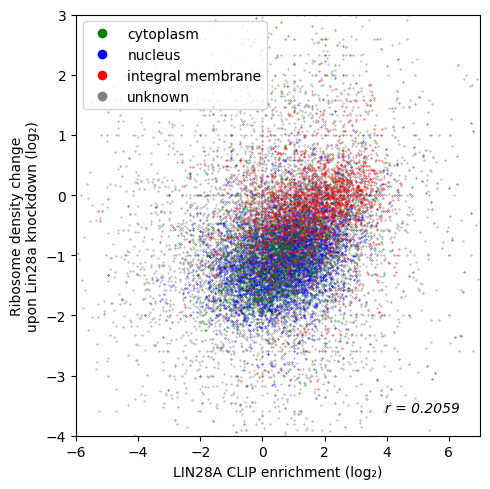

In [33]:
import matplotlib.patches as mpatches
import ssl

cnts = cnts_filtered
ssl._create_default_https_context = ssl._create_unverified_context
mouselocal = pd.read_csv('https://hyeshik.qbio.io/binfo/mouselocalization-20210507.txt', sep='\t')
mouselocal.rename(columns={'gene_id': 'Geneid'}, inplace=True)

# cnts_df = cnts

cnts = cnts.replace([np.inf, -np.inf], np.nan).dropna(subset=['clip_enrichment_log2', 'rden_change_log2'])
cnts.reset_index(inplace=True)
cnts['Geneid'] = cnts['Geneid'].str.split('.').str[0]
# cnts.head()
# mouselocal.head()
mouselocal_unique = mouselocal.drop_duplicates(subset='Geneid', keep='first')
cnts_local = cnts.merge(mouselocal_unique, how='left', on='Geneid')

# cnts_local = cnts.merge(mouselocal, how = 'left', on = 'Geneid')
# cnts_local.head()

cnts_local['type'] = cnts_local['type'].fillna('unknown')
colors = {'cytoplasm': 'green', 'nucleus': 'blue', 'integral membrane': 'red', 'unknown': 'gray'}

mask = (
    cnts_local['clip_enrichment_log2'].notna() &
    cnts_local['rden_change_log2'].notna() &
    np.isfinite(cnts_local['clip_enrichment_log2']) &
    np.isfinite(cnts_local['rden_change_log2'])
)

r, _ = pearsonr(
    cnts_local.loc[mask, 'clip_enrichment_log2'],
    cnts_local.loc[mask, 'rden_change_log2']
)

cnts_local_small = cnts_local[mask].copy()
cnts_local = cnts_local_small

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
for t in cnts_local['type'].unique():
    df_subset = cnts_local[cnts_local['type'] == t]
    ax.scatter(df_subset['clip_enrichment_log2'], df_subset['rden_change_log2'],
                color=colors[t], label=t, alpha=1, s = 0.1)

ax.set_ylabel('Ribosome density change\nupon Lin28a knockdown (log₂)')
ax.set_xlabel(r'LIN28A CLIP enrichment (log₂)')

ax.text(0.95, 0.05, f'r = {r:.4f}', transform=ax.transAxes,
        ha='right', va='bottom', fontsize=10, style='italic')
ax.set_xlim(-6, 7)
ax.set_ylim(-4, 3)
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=label, markersize=8, markerfacecolor=color)
                  for label, color in colors.items()]
ax.legend(handles=legend_handles, loc='upper left')

plt.tight_layout()
plt.savefig("YOA2.png", dpi=300, bbox_inches='tight')
plt.show()

In [34]:
dup_counts = mouselocal['Geneid'].value_counts()
print(dup_counts[dup_counts > 1].head())

Geneid
ENSMUSG00000094777    9
ENSMUSG00000069301    9
ENSMUSG00000061615    9
ENSMUSG00000069309    9
ENSMUSG00000071516    9
Name: count, dtype: int64


In [35]:
print(cnts_local[['clip_enrichment_log2', 'rden_change_log2']].isna().sum())
print(np.isfinite(cnts_local[['clip_enrichment_log2', 'rden_change_log2']]).sum())


print(cnts_local[['clip_enrichment_log2', 'rden_change_log2']].isna().sum())
print(np.isfinite(cnts_local[['clip_enrichment_log2', 'rden_change_log2']]).sum())

print(len(cnts_filtered))
print(len(cnts))
print(len(cnts_local))



clip_enrichment_log2    0
rden_change_log2        0
dtype: int64
clip_enrichment_log2    16201
rden_change_log2        16201
dtype: int64
clip_enrichment_log2    0
rden_change_log2        0
dtype: int64
clip_enrichment_log2    16201
rden_change_log2        16201
dtype: int64
16201
16201
16201


In [36]:
cnts_2 = cnts_local[(cnts_local['RNA-control.bam'] >= 30) & (cnts_local['RNA-siLuc.bam'] >= 30) & (cnts_local['RPF-siLuc.bam'] >= 80)]
cnts_chopped = cnts_2.replace([np.inf, -np.inf], np.nan).dropna(subset=['clip_enrichment_log2', 'rden_change_log2'])

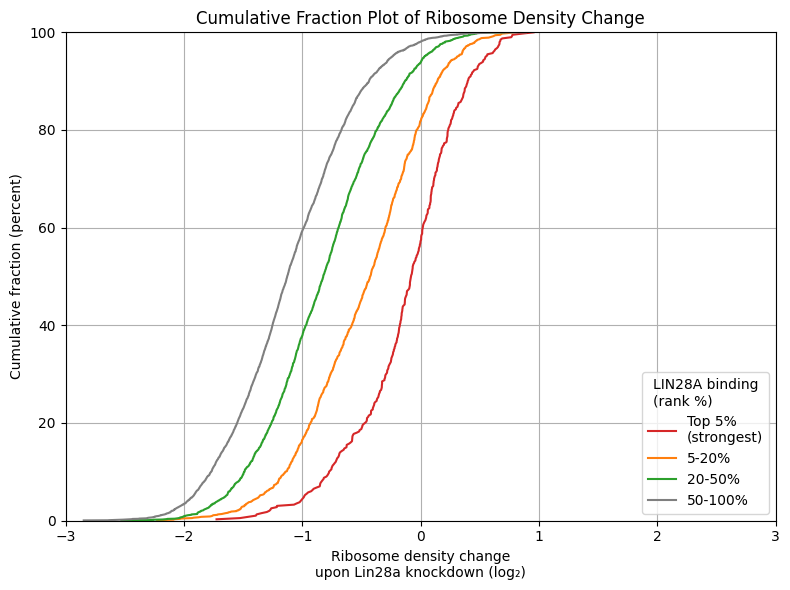

In [37]:
cnts_chopped['rank'] = cnts_chopped['clip_enrichment'].rank(ascending=False)
thrlist = [0.05, 0.20, 0.50, 1.00]
grouplist = ['Top 5%\n(strongest)', '5-20%', '20-50%', '50-100%']
perce = [cnts_chopped['rank'].quantile(q) for q in thrlist]
# for i in perce :
#   print(i)
cnts_chopped['group'] = pd.cut(cnts_chopped['rank'], bins=[0] + perce, labels=grouplist)

colormap = {
    'Top 5%\n(strongest)': '#d62728',
    '5-20%': '#ff7f0e',
    '20-50%': '#2ca02c',
    '50-100%': '#7f7f7f'
}

plt.figure(figsize=(8, 6))

for group in grouplist:
    datadata = cnts_chopped[cnts_chopped['group'] == group]['rden_change_log2'].sort_values()
    cumfrac = np.arange(1, len(datadata) + 1)* 100  / len(datadata)
    plt.plot(datadata,
             cumfrac,
             label=group,
             color=colormap[group])
    # plt.scatter(datadata,
    #             cumfrac,
    #             color=colormap[group],
    #             label=None)
plt.xlim(-3, 3)
plt.ylim(0, 100)
plt.xlabel('Ribosome density change\nupon Lin28a knockdown (log₂)')
plt.ylabel('Cumulative fraction (percent)')
plt.legend(title='LIN28A binding\n(rank %)', loc='lower right')
plt.title('Cumulative Fraction Plot of Ribosome Density Change')
plt.grid(True)
plt.tight_layout()
plt.savefig("YOA3.png", dpi=300, bbox_inches='tight')
plt.show()

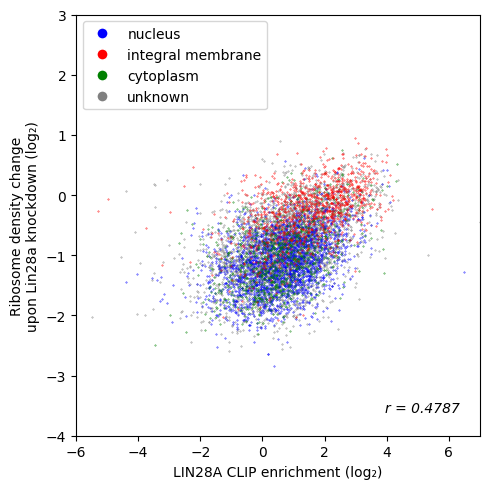

In [38]:
from matplotlib import pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
import ssl

r, p_value = pearsonr(cnts_chopped['clip_enrichment_log2'], cnts_chopped['rden_change_log2'])

colors = {'nucleus': 'blue', 'integral membrane': 'red', 'cytoplasm': 'green', 'unknown': 'gray'}
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
for t in cnts_chopped['type'].unique():
    df_subset = cnts_chopped[cnts_chopped['type'] == t]
    ax.scatter(df_subset['clip_enrichment_log2'], df_subset['rden_change_log2'],
                color=colors[t], label=t, alpha=1, s = 0.1)

ax.set_ylabel('Ribosome density change\nupon Lin28a knockdown (log₂)')
ax.set_xlabel(r'LIN28A CLIP enrichment (log₂)')

ax.text(0.95, 0.05, f'r = {r:.4f}', transform=ax.transAxes,
        ha='right', va='bottom', fontsize=10, style='italic')
# ax.set_xlim(-4, 6)
# ax.set_ylim(-3, 1)
ax.set_xlim(-6, 7)
ax.set_ylim(-4, 3)
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=label, markersize=8, markerfacecolor=color)
                  for label, color in colors.items()]
ax.legend(handles=legend_handles, loc='upper left')
plt.tight_layout()
plt.savefig("YOA4.png", dpi=300, bbox_inches='tight')
plt.show()

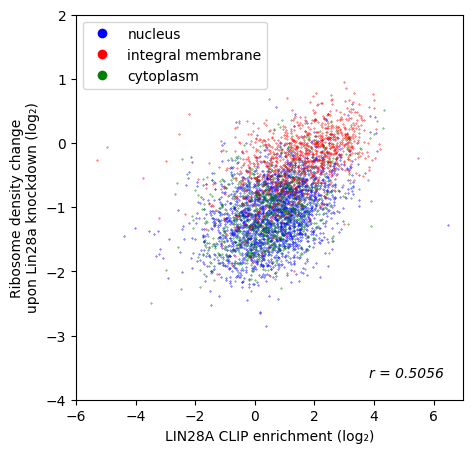

In [39]:
# Figure S6

from matplotlib import pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
import ssl

cnts_df2 = cnts_chopped

cnts_df2['type'] = cnts_df2['type'].fillna('unknown')
cnts_df = cnts_df2[cnts_df2['type'] != 'unknown']
r, p_value = pearsonr(cnts_df['clip_enrichment_log2'], cnts_df['rden_change_log2'])

colors = {'nucleus': 'blue', 'integral membrane': 'red', 'cytoplasm': 'green'}
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
for t in cnts_df['type'].unique():
    df_subset = cnts_df[cnts_df['type'] == t]
    ax.scatter(df_subset['clip_enrichment_log2'], df_subset['rden_change_log2'],
                color=colors[t], label=t, alpha=1, s = 0.1)

ax.set_ylabel('Ribosome density change\nupon Lin28a knockdown (log₂)')
ax.set_xlabel(r'LIN28A CLIP enrichment (log₂)')

ax.text(0.95, 0.05, f'r = {r:.4f}', transform=ax.transAxes,
        ha='right', va='bottom', fontsize=10, style='italic')
# ax.set_xlim(-4, 6)
# ax.set_ylim(-3, 1)
ax.set_xlim(-6, 7)
ax.set_ylim(-4, 2)
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=label, markersize=8, markerfacecolor=color)
                  for label, color in colors.items()]
ax.legend(handles=legend_handles)

In [40]:
# !wget http://current.geneontology.org/annotations/mgi.gaf.gz
# !gunzip mgi.gaf.gz
#!wget http://www.informatics.jax.org/downloads/reports/MGI_EntrezGene.rpt
# !head MGI_EntrezGene.rpt
# !cut -f1,2 MGI_EntrezGene.rpt | grep "ENSMUS" | awk '{print $1"\t"$2}' > mgi_ensmus
# !awk -F"\t" 'FNR==NR{name[$1]=$2; next}{if($2 in name){print name[$2]"\t"$5}}' mgi_ensmus mgi.gaf > go_ensembl

In [41]:
!pip install biomart

In [50]:
from biomart import BiomartServer
import pandas as pd
from io import StringIO

# Ensembl BioMart 서버 접속
server = BiomartServer("http://www.ensembl.org/biomart")
dataset = server.datasets['mmusculus_gene_ensembl']

# 검색 쿼리
response = dataset.search({
    'attributes': [
        'ensembl_gene_id',  # ENSMUSGxxxxx
        'go_id',            # GO:xxxxxxx
        'name_1006',        # GO term 이름
        'namespace_1003'    # biological_process 등
    ]
})

# 텍스트로 변환 후 DataFrame 처리



In [51]:
df_go = pd.read_csv(StringIO(response.text), sep='\t', header=None,
                    names=['Geneid', 'GO', 'GO_name', 'GO_domain'])

# NaN 제거
df_go = df_go[df_go['GO'].notna()]

In [52]:
# df_go.head()
# # len(df_go)


In [53]:
cnts_go = cnts_local.merge(df_go, how = 'left', on = 'Geneid')
cnts_go.head()
print(cnts_go.columns)

Index(['Geneid', 'Chr', 'Start', 'End', 'Strand', 'Length', 'CLIP-35L33G.bam',
       'RNA-control.bam', 'RNA-siLin28a.bam', 'RNA-siLuc.bam',
       'RPF-siLin28a.bam', 'RPF-siLuc.bam', 'clip_enrichment', 'rden_change',
       'clip_enrichment_log2', 'rden_siLin28a', 'rden_siLuc',
       'rden_change_log2', 'Gene names', 'type', 'GO', 'GO_name', 'GO_domain'],
      dtype='object')


In [64]:
print(len(cnts_local))
print(len(cnts_go))
cnts_go.head()

16201
221014


,Geneid,Chr,Start,End,Strand,Length,CLIP-35L33G.bam,RNA-control.bam,RNA-siLin28a.bam,RNA-siLuc.bam,...,rden_change,clip_enrichment_log2,rden_siLin28a,rden_siLuc,rden_change_log2,Gene names,type,GO,GO_name,GO_domain
0,ENSMUSG00000102343,chr1;chr1;chr1;chr1;chr1,3975962;4054448;4055383;4055383;4056370,3976357;4054521;4056207;4055574;4056438,-;-;-;-;-,1364,67,31,207,157,...,0.379227,1.111893,0.009615,0.018987,-1.398866,NaN,unknown,NaN,NaN,NaN
1,ENSMUSG00000025902,chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;c...,4561154;4561473;4561613;4561936;4562680;456268...,4562891;4562886;4562891;4562891;4563827;456289...,-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;...,4772,6,1,8,5,...,0.416667,2.584963,0.333333,0.666667,-1.263034,Sox17 Sox-17,nucleus,GO:0010467,gene expression,biological_process
2,ENSMUSG00000025902,chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;c...,4561154;4561473;4561613;4561936;4562680;456268...,4562891;4562886;4562891;4562891;4563827;456289...,-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;...,4772,6,1,8,5,...,0.416667,2.584963,0.333333,0.666667,-1.263034,Sox17 Sox-17,nucleus,GO:1990830,cellular response to leukemia inhibitory factor,biological_process
3,ENSMUSG00000025902,chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;c...,4561154;4561473;4561613;4561936;4562680;456268...,4562891;4562886;4562891;4562891;4563827;456289...,-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;...,4772,6,1,8,5,...,0.416667,2.584963,0.333333,0.666667,-1.263034,Sox17 Sox-17,nucleus,GO:0005634,nucleus,cellular_component
4,ENSMUSG00000025902,chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;c...,4561154;4561473;4561613;4561936;4562680;456268...,4562891;4562886;4562891;4562891;4563827;456289...,-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;...,4772,6,1,8,5,...,0.416667,2.584963,0.333333,0.666667,-1.263034,Sox17 Sox-17,nucleus,GO:0043565,sequence-specific DNA binding,molecular_function


In [55]:
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

# 필요한 컬럼 필터
df = cnts_go[['GO_name', 'rden_change_log2', 'clip_enrichment_log2']].dropna()

# GO term 목록
terms = df['GO_name'].unique()
results = []

for term in terms:
    group1 = df[df['GO_name'] == term]
    group2 = df[df['GO_name'] != term]

    if len(group1) < 5 or len(group2) < 5:
        continue

    # Mann-Whitney U test on rden_change_log2
    stat, pval = mannwhitneyu(group1['rden_change_log2'], group2['rden_change_log2'], alternative='two-sided')

    results.append({
        'GO_name': term,
        'n_genes': len(group1),
        'pval': pval,
        'rden_change_log2_mean': group1['rden_change_log2'].mean(),
        'clip_enrichment_log2_mean': group1['clip_enrichment_log2'].mean()
    })

# 데이터프레임으로 정리
mw_df = pd.DataFrame(results)

# FDR 보정
mw_df['fdr'] = multipletests(mw_df['pval'], method='fdr_bh')[1]


In [56]:
# mw_df.head()

In [57]:
mw_df_tmp2 = mw_df[mw_df['fdr'] <= 0.05]
mw_df_tmp = mw_df_tmp2.sort_values('fdr', ascending=False)

In [58]:
mw_df_tmp.to_csv("mw_df_tmp.tsv", sep='\t', index=False)

In [59]:
!head mw_df_tmp.tsv

GO_name	n_genes	pval	rden_change_log2_mean	clip_enrichment_log2_mean	fdr
BMP receptor activity	12	0.005887655778703569	-0.2769815474126736	2.7355090680218113	0.049902839389333764
camera-type eye development	45	0.005869849258594324	-0.5295370589051227	1.4690600957279245	0.04982486416129405
intermediate filament	38	0.0058535220549727806	-1.1104987547039584	0.531434217139469	0.049759235207397105
P-type calcium transporter activity	6	0.005821878805143159	-0.09756269569720971	2.671184906391883	0.04956302412202022
ribonucleoprotein complex	323	0.005797590604188683	-0.9552652677593545	0.45603637830899824	0.049428942573856084
negative regulation of T cell activation	13	0.0057259755241742824	-0.18895844842855458	1.5093237015167804	0.048890372137824364
positive regulation of cell-substrate adhesion	20	0.005696604221691306	-0.27551855642833323	1.2690710087775372	0.04871143550867204
glycosaminoglycan metabolic process	6	0.005692378163096474	0.03440745112213448	1.6089557016897296	0.0487114355086720

In [60]:
mw_df_tmp = pd.read_csv("mw_df_tmp.tsv", sep="\t")

In [61]:
# 기준별 상위 5개 GO term 추출
top_fdr = mw_df_tmp.sort_values('fdr').head(3)['GO_name']
top_clip = mw_df_tmp.sort_values('clip_enrichment_log2_mean', ascending=False).head(3)['GO_name']
top_genecount = mw_df_tmp.sort_values('n_genes', ascending=False).head(3)['GO_name']

# 세 리스트를 합치고 중복 제거
highlight_terms = list(set(top_fdr) | set(top_clip) | set(top_genecount))

print("Highlight terms (총 {}개):".format(len(highlight_terms)))
print(highlight_terms)


Highlight terms (총 9개):
['membrane', 'cytoplasm', 'endoplasmic reticulum', 'endoplasmic reticulum membrane', 'protein binding', 'mRNA branch site recognition', 'nucleus', 'negative regulation of plasminogen activation', 'triplet codon-amino acid adaptor activity']


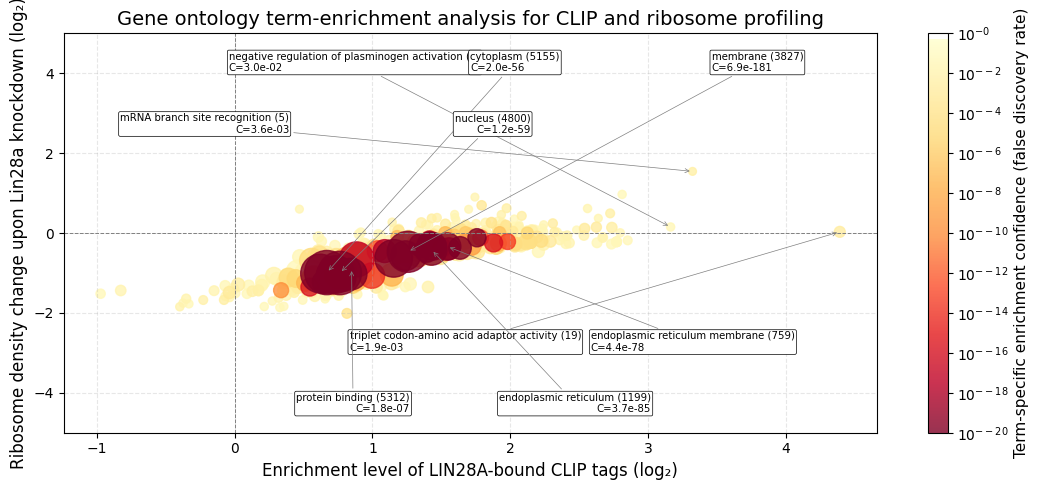

In [62]:
!pip install adjustText
# 큰거, 엄청 빨간거, 아웃라이어 term
from adjustText import adjust_text
from matplotlib.colors import LogNorm
# highlight_terms = [
#     'extracellular region', 'endoplasmic reticulum', 'endoplasmic reticulum membrane',
#     'glycosaminoglycan metabolic process', 'endoplasmic reticulum lumen', 'cell surface',
#     'calcium ion binding', 'Golgi apparatus', 'nucleosome assembly', 'nucleosome',
#     'mitochondrion', 'nucleus', 'cytoplasm'
# ]
highlight_df = mw_df_tmp[mw_df_tmp['GO_name'].isin(highlight_terms)]
mw_df_tmp['point_size'] = (np.sqrt(mw_df_tmp['n_genes']) / np.sqrt(50)) * 100


fig, ax = plt.subplots(figsize=(11, 5))
sc = ax.scatter(
    mw_df_tmp['clip_enrichment_log2_mean'],
    mw_df_tmp['rden_change_log2_mean'],
    s=mw_df_tmp['point_size'],
    c=mw_df_tmp['fdr'],
    cmap='YlOrRd_r',
    norm=LogNorm(vmax=0.5, vmin=1e-20),
    alpha=0.8
)

# ax.set_xlim(-3.5, 4.5)  # 전체 분포 보여주고
# ax.set_ylim(-2.8, 1.0)  # 상위 1% 정도 여유

# ax.set_xlim(-2, 5)
ax.set_ylim(-5, 5)
# label 개수, x좌표 범위
n_labels = len(highlight_df)
xlim = ax.get_xlim()
x_margin = 1.2  # ✅ 간격 더 넓힘

# 좌우로 넓게 퍼뜨리기
x_positions = np.linspace(xlim[0] + x_margin, xlim[1] - x_margin, n_labels)

# y축 범위 안쪽 여유
ylim = ax.get_ylim()
y_padding = 0.2 * (ylim[1] - ylim[0])
y_top1 = ylim[1]- y_padding/2
y_top = ylim[1] - y_padding
y_bottom = ylim[0] + y_padding
y_bottom1 = ylim[0] + y_padding/2
# annotation 반복
for i, (_, row) in enumerate(highlight_df.iterrows()):
    label = f"{row['GO_name']} ({row['n_genes']})\nC={row['fdr']:.1e}"
    if(i%4==0) : y_target = y_top1
    elif (i%4==1) : y_target = y_top
    elif (i%4==2) : y_target = y_bottom
    else : y_target = y_bottom1
    # y_target = y_top if i % 2 == 0 else y_bottom
    x_target = x_positions[i]

    # 가운데 붙이면 겹침 → 좌우 혼용
    halign = 'left' if i % 2 == 0 else 'right'

    ax.annotate(
        label,
        xy=(row['clip_enrichment_log2_mean'], row['rden_change_log2_mean']),
        xytext=(x_target, y_target),
        textcoords='data',
        ha=halign,
        va='bottom' if i % 2 == 0 else 'top',
        fontsize=7.3,
        bbox=dict(boxstyle='round,pad=0.15', fc='white', ec='black', lw=0.5),
        arrowprops=dict(arrowstyle='->', color='gray', lw=0.5)
    )



# 컬러바
cbar = fig.colorbar(sc, ax=ax)
cbar.set_label('Term-specific enrichment confidence (false discovery rate)', fontsize=11)
log_ticks = [10**(-i) for i in range(0, 21, 2)]
cbar.set_ticks(log_ticks)
cbar.ax.set_yticklabels([f"$10^{{-{int(np.log10(t))}}}$" for t in log_ticks])

# # 축 및 타이틀
ax.set_xlabel('Enrichment level of LIN28A-bound CLIP tags (log₂)', fontsize=12)
ax.set_ylabel('Ribosome density change upon Lin28a knockdown (log₂)', fontsize=12)
ax.set_title('Gene ontology term-enrichment analysis for CLIP and ribosome profiling', fontsize=14)
ax.axhline(0, linestyle='--', color='gray', linewidth=0.7)
ax.axvline(0, linestyle='--', color='gray', linewidth=0.7)
ax.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig("my_figure2.png", dpi=300, bbox_inches='tight')
plt.show()